In [1]:
import os
import shutil
from pathlib import Path
import random
import yaml

In [2]:
!pip install -U ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 1.4 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 3.9 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 20.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab-widgets 3.0.9
    Uninstalling jupyterlab-widgets-3.0.9:
      Successfully uninstalled jupyterlab-widgets-3.0.9
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [3]:
dataset_path = Path('/kaggle/input/atomichack')
output_path = Path('/kaggle/working/yolo_dataset/')
images_path = output_path / 'images'
labels_path = output_path / 'labels'

In [4]:
(images_path / 'train').mkdir(parents=True, exist_ok=True)
(images_path / 'val').mkdir(parents=True, exist_ok=True)
(labels_path / 'train').mkdir(parents=True, exist_ok=True)
(labels_path / 'val').mkdir(parents=True, exist_ok=True)

In [5]:
image_files = sorted([f for f in dataset_path.glob('*.jpg')])
annotation_files = sorted([f for f in dataset_path.glob('*.txt')])

In [6]:
data = list(zip(image_files, annotation_files))
random.shuffle(data)
image_files, annotation_files = zip(*data)

In [7]:
split_index = int(0.8 * len(image_files))
train_images = image_files[:split_index]
train_annotations = annotation_files[:split_index]
val_images = image_files[split_index:]
val_annotations = annotation_files[split_index:]

In [8]:
for img_file, ann_file in zip(train_images, train_annotations):
    shutil.copy(img_file, images_path / 'train' / img_file.name)
    shutil.copy(ann_file, labels_path / 'train' / ann_file.name)

for img_file, ann_file in zip(val_images, val_annotations):
    shutil.copy(img_file, images_path / 'val' / img_file.name)
    shutil.copy(ann_file, labels_path / 'val' / ann_file.name)

In [9]:
data_yaml = {
    'train': str(images_path / 'train'),
    'val': str(images_path / 'val'),
    'nc': 5,
    'names': ['adj', 'int', 'geo', 'pro', 'non']
}

In [10]:
with open(output_path / 'data.yaml', 'w') as yaml_file:
    yaml.dump(data_yaml, yaml_file, default_flow_style=False)

In [11]:
import torch 
import torchvision

In [12]:
import os
HOME = os.getcwd()

In [13]:
!pip install -q git+https://github.com/THU-MIG/yolov10.git

In [15]:
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10x.pt
!ls -lh {HOME}/weights

total 123M
-rw-r--r-- 1 root root 123M May 26 15:54 yolov10x.pt


In [18]:
from ultralytics import YOLOv10

model = YOLOv10(f'{HOME}/weights/yolov10x.pt')

In [19]:
model.to('cuda')

YOLOv10(
  (model): YOLOv10DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(80, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(80, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(160, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(160, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(160, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(400, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(160, eps=0.001, momentum=0.03, affine=Tru

In [20]:
model.train(data='/kaggle/working/yolo_dataset/data.yaml',
            epochs=100,
            imgsz=640,
            seed=42,
            batch=8)

New https://pypi.org/project/ultralytics/8.2.32 available 😃 Update with 'pip install -U ultralytics'
engine/trainer: task=detect, mode=train, model=/kaggle/working/weights/yolov10x.pt, data=/kaggle/working/yolo_dataset/data.yaml, epochs=100, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=cuda:0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_

100%|██████████| 755k/755k [00:00<00:00, 15.5MB/s]
2024-06-15 07:09:44.140518: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-15 07:09:44.140623: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-15 07:09:44.324385: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1    213120  ultralytics.nn.modules.block.SCDown          [320, 640, 3, 2]              
  6                  -1  6   4604160  ultralytics.nn.modules.block.C2fCIB          [640, 640, 6, True]           
  7                  -1  1    417920  ultralytics

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.23M/6.23M [00:00<00:00, 73.7MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/yolo_dataset/labels/train... 929 images, 116 backgrounds, 0 corrupt: 100%|██████████| 929/929 [00:00<00:00, 1393.00it/s]

train: New cache created: /kaggle/working/yolo_dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/yolo_dataset/labels/val... 233 images, 24 backgrounds, 0 corrupt: 100%|██████████| 233/233 [00:00<00:00, 1341.32it/s]


val: New cache created: /kaggle/working/yolo_dataset/labels/val.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 185 weight(decay=0.0), 198 weight(decay=0.0005), 197 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      1/100      10.7G      2.364      2.949      1.781      2.301      4.365       1.54          1        640: 100%|██████████| 117/117 [01:19<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]

                   all        233        689      0.523     0.0395     0.0232    0.00714



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      2/100      11.1G      2.352      2.307      1.764      2.397      2.757      1.571          2        640: 100%|██████████| 117/117 [01:16<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.19it/s]

                   all        233        689      0.335      0.192      0.109     0.0291



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      3/100      11.1G      2.337      2.229      1.792      2.431      2.715      1.614          2        640: 100%|██████████| 117/117 [01:15<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.20it/s]

                   all        233        689        0.2      0.328      0.196     0.0586



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      4/100        11G      2.288      2.057      1.742      2.392      2.537      1.605          2        640: 100%|██████████| 117/117 [01:15<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.19it/s]

                   all        233        689      0.282      0.336      0.204     0.0648



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      5/100      11.1G      2.272       2.02      1.732      2.391      2.427      1.585         10        640: 100%|██████████| 117/117 [01:15<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]

                   all        233        689      0.344      0.334      0.262     0.0871



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      6/100      11.1G      2.221      1.949       1.71      2.303      2.355      1.561          1        640: 100%|██████████| 117/117 [01:15<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]

                   all        233        689      0.302      0.342      0.233      0.075



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      7/100      11.1G      2.122      1.734      1.652       2.26       2.14      1.531          6        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]

                   all        233        689       0.37      0.387      0.325       0.12



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      8/100      11.1G      2.066      1.649      1.628      2.237      2.009      1.528          7        640: 100%|██████████| 117/117 [01:15<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]

                   all        233        689      0.507      0.435      0.421      0.151



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      9/100      11.1G      2.055      1.573      1.574      2.213      1.899      1.468          4        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]

                   all        233        689      0.525      0.452      0.445      0.172



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     10/100      11.1G       2.03       1.54      1.572      2.201       1.82       1.47          8        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]

                   all        233        689      0.525      0.432      0.402      0.139



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     11/100      11.1G      1.965        1.5      1.566      2.145      1.803      1.478          3        640: 100%|██████████| 117/117 [01:15<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]

                   all        233        689      0.596      0.509      0.509      0.202



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     12/100        11G      1.938      1.488      1.506      2.113      1.769      1.414          0        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]

                   all        233        689      0.665      0.566      0.595      0.245



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     13/100      11.1G      1.907      1.346      1.505      2.084      1.562      1.415          1        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]

                   all        233        689      0.601      0.527      0.562      0.254



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     14/100      11.1G      1.942      1.358      1.489      2.131      1.593      1.408         13        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.15it/s]

                   all        233        689      0.674        0.6      0.621      0.285



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     15/100        11G      1.884        1.3      1.499      2.079      1.525      1.419          4        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.24it/s]

                   all        233        689      0.715      0.557      0.639      0.287



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     16/100      11.1G      1.859      1.279       1.45      2.068      1.487      1.367          9        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.24it/s]

                   all        233        689      0.655      0.576      0.578      0.249



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     17/100      11.1G      1.829      1.204      1.447      2.035      1.408      1.378          4        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]

                   all        233        689      0.701      0.532      0.602      0.267



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     18/100      11.1G      1.812      1.168      1.425      2.025      1.364      1.354         12        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.25it/s]

                   all        233        689      0.676      0.603      0.671      0.295



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     19/100        11G      1.783      1.162      1.408      1.995      1.379      1.346          3        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.19it/s]

                   all        233        689      0.732      0.643      0.696      0.325



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     20/100        11G       1.79      1.117      1.428      1.984      1.307      1.363          4        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]

                   all        233        689      0.725      0.616       0.68       0.32



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     21/100      11.1G      1.746      1.073      1.399      1.963      1.235      1.345         17        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.22it/s]

                   all        233        689      0.735      0.652      0.702      0.315



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     22/100      11.1G      1.774       1.14      1.415      1.953      1.273      1.335          1        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.15it/s]

                   all        233        689      0.664      0.636      0.684      0.314



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     23/100      11.1G      1.707      1.043      1.354      1.898      1.233      1.285          6        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]

                   all        233        689      0.693        0.7        0.7      0.318



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     24/100      11.1G        1.7      1.047      1.359      1.881      1.222      1.297         15        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]

                   all        233        689        0.7      0.662      0.701      0.329



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     25/100      11.1G      1.669      1.022      1.332      1.878      1.178      1.279          2        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]

                   all        233        689      0.774      0.666      0.723      0.327



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     26/100        11G      1.654     0.9787      1.348      1.848      1.116      1.286          5        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]

                   all        233        689      0.804      0.718      0.759      0.346



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     27/100      11.1G       1.64     0.9889      1.314      1.878      1.102      1.267         10        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.19it/s]

                   all        233        689      0.746      0.727      0.771      0.358



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     28/100        11G      1.636     0.9721      1.329      1.878      1.112      1.277         14        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.24it/s]

                   all        233        689      0.729      0.653       0.71      0.347



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     29/100      11.1G      1.579     0.9456      1.309      1.804      1.058       1.26          0        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.25it/s]

                   all        233        689      0.798      0.689       0.75      0.347



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     30/100      11.1G      1.607     0.9512      1.311      1.815      1.096      1.254         14        640: 100%|██████████| 117/117 [01:15<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.19it/s]

                   all        233        689       0.81      0.723      0.768      0.361



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     31/100        11G      1.601     0.9368      1.311      1.823      1.056      1.255          2        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]

                   all        233        689      0.763      0.679       0.74      0.372



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     32/100      11.1G      1.588     0.9161      1.305      1.801      1.046      1.255          6        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.26it/s]

                   all        233        689      0.777      0.728        0.8      0.386



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     33/100      11.1G      1.557     0.8663      1.288       1.79     0.9651      1.242          7        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.24it/s]

                   all        233        689      0.745       0.72      0.771      0.368



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     34/100      11.1G      1.551     0.8648      1.262      1.773     0.9604      1.209          7        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]

                   all        233        689      0.803      0.686       0.77      0.375



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     35/100      11.1G       1.52     0.8501       1.26      1.736      0.962      1.212          4        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]

                   all        233        689      0.772      0.716      0.769      0.367



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     36/100        11G      1.508     0.8304      1.246      1.719     0.9249      1.198          4        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.19it/s]

                   all        233        689      0.778       0.77      0.807        0.4



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     37/100      11.1G      1.503     0.8337      1.252       1.73     0.9261      1.209         11        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.19it/s]

                   all        233        689      0.803      0.776      0.813      0.384



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     38/100      11.1G      1.536     0.8534      1.281      1.745     0.9463       1.23          5        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.19it/s]

                   all        233        689      0.795      0.753      0.796      0.385



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     39/100      11.1G      1.492     0.8291      1.248      1.709     0.9414      1.199          7        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.23it/s]

                   all        233        689      0.763      0.754      0.795      0.381



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     40/100      11.1G      1.488      0.811      1.255      1.696     0.8806      1.209          5        640: 100%|██████████| 117/117 [01:15<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.23it/s]

                   all        233        689      0.826      0.741      0.816      0.391



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     41/100      11.1G      1.473     0.8172      1.239      1.704     0.9006      1.202          5        640: 100%|██████████| 117/117 [01:15<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.23it/s]

                   all        233        689      0.819      0.741      0.809      0.385



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     42/100      11.1G      1.475     0.7903      1.251      1.689     0.8762      1.208          1        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.22it/s]

                   all        233        689      0.775      0.752      0.805      0.391



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     43/100      11.1G      1.475     0.8042      1.252      1.685      0.894      1.199          2        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]

                   all        233        689       0.86      0.708      0.789       0.39



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     44/100        11G      1.449     0.7774      1.214      1.679     0.8813      1.176         16        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.20it/s]

                   all        233        689      0.804      0.744      0.791      0.382



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     45/100      11.1G      1.452     0.7849      1.222       1.68     0.8576      1.179          4        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]

                   all        233        689      0.842       0.74      0.805      0.377



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     46/100      11.1G      1.434     0.7499      1.207      1.673     0.8339      1.164         13        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]

                   all        233        689      0.843      0.746      0.822      0.403



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     47/100        11G      1.461     0.7717      1.224      1.697     0.8526      1.187          4        640: 100%|██████████| 117/117 [01:15<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.20it/s]

                   all        233        689        0.8      0.772      0.819      0.393



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     48/100      11.1G      1.433     0.7643      1.216      1.652     0.8313       1.17         18        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.15it/s]

                   all        233        689      0.818      0.753      0.818      0.399



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     49/100        11G      1.422     0.7467      1.215      1.634     0.8061       1.17          1        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.20it/s]

                   all        233        689      0.801      0.764      0.812      0.404



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     50/100      11.1G      1.395     0.7422      1.208      1.624     0.8212      1.169         13        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.19it/s]

                   all        233        689      0.803      0.739      0.797       0.39



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     51/100      11.1G      1.393      0.726      1.202      1.614     0.7904      1.164          6        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]

                   all        233        689      0.842       0.76      0.828      0.394



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     52/100        11G      1.396     0.7253      1.192      1.617     0.7836      1.151          2        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.25it/s]

                   all        233        689      0.811      0.809      0.837      0.396



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     53/100      11.1G      1.386     0.7185       1.19      1.617     0.7667      1.155          5        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]

                   all        233        689      0.798      0.755      0.805      0.383



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     54/100      11.1G      1.353     0.7174      1.182      1.592     0.7686      1.146          2        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]

                   all        233        689       0.84      0.777       0.84      0.416



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     55/100      11.1G      1.377      0.718      1.191      1.615     0.7744      1.154          6        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.19it/s]

                   all        233        689       0.86      0.755      0.821      0.401



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     56/100      11.1G      1.349     0.7011      1.176      1.595      0.763       1.14          5        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]

                   all        233        689      0.775      0.799      0.815      0.395



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     57/100      11.1G      1.317     0.6832      1.152      1.563     0.7177       1.12          7        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.20it/s]

                   all        233        689      0.814      0.717      0.784      0.387



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     58/100      11.1G      1.336     0.6922      1.169      1.569     0.7388      1.139          8        640: 100%|██████████| 117/117 [01:15<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.20it/s]

                   all        233        689      0.828      0.801      0.838      0.418



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     59/100      11.1G      1.317     0.6863      1.159      1.553      0.721       1.13         13        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]

                   all        233        689      0.788      0.778      0.825      0.396



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     60/100        11G      1.314     0.6766      1.155      1.547     0.7194      1.122          2        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.20it/s]

                   all        233        689      0.841       0.75      0.792       0.39



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     61/100      11.1G      1.302     0.6633      1.144      1.533     0.6956      1.111          3        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]

                   all        233        689       0.83       0.78      0.834       0.42



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     62/100      11.1G      1.282     0.6611      1.159      1.506     0.7032      1.122          3        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.15it/s]

                   all        233        689      0.846      0.761      0.821      0.398



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     63/100      11.1G       1.27     0.6505      1.137      1.484     0.6905      1.108          4        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]

                   all        233        689      0.886      0.728      0.819      0.406



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     64/100      11.1G      1.288     0.6634      1.149       1.52     0.7166      1.119          2        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]

                   all        233        689      0.822      0.792      0.822      0.409



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     65/100        11G      1.263     0.6431      1.131      1.483     0.6967      1.106          5        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]

                   all        233        689      0.826      0.778      0.816      0.394



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     66/100      11.1G      1.226     0.6199      1.111      1.451     0.6651      1.083          4        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]

                   all        233        689      0.817      0.802      0.838      0.416



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     67/100      11.1G      1.253     0.6414      1.135      1.468     0.6993      1.104          8        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]

                   all        233        689      0.834      0.753      0.826      0.408



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     68/100        11G      1.229     0.6144      1.118      1.455     0.6487       1.09          8        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.23it/s]

                   all        233        689      0.819      0.798      0.831      0.411



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     69/100      11.1G       1.21     0.6103      1.107      1.454     0.6403      1.081          8        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]

                   all        233        689      0.855      0.767      0.836      0.412



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     70/100      11.1G      1.207     0.6025       1.11      1.434     0.6181      1.086          3        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.23it/s]

                   all        233        689      0.816       0.81      0.855      0.426



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     71/100      11.1G      1.213      0.598      1.103      1.456     0.6246      1.073          3        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]

                   all        233        689      0.799      0.785      0.818      0.397



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     72/100      11.1G      1.206      0.602        1.1      1.434      0.628      1.073          2        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.22it/s]

                   all        233        689      0.849      0.794      0.842      0.407



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     73/100      11.1G      1.185      0.606      1.085      1.427     0.6318      1.067         15        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]

                   all        233        689       0.83      0.789      0.834      0.412



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     74/100      11.1G      1.176     0.5912       1.09      1.411     0.6159      1.063          5        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]

                   all        233        689      0.827      0.789      0.837      0.421



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     75/100        11G      1.179     0.5881      1.087      1.404     0.5967      1.057          0        640: 100%|██████████| 117/117 [01:15<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.19it/s]

                   all        233        689      0.864      0.751      0.837      0.419



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     76/100        11G      1.151     0.5781       1.09      1.378     0.6004      1.066         11        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]

                   all        233        689      0.849      0.767       0.84      0.409



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     77/100      11.1G      1.183     0.5923       1.08      1.405      0.612      1.061          8        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]

                   all        233        689      0.826      0.818      0.844      0.417



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     78/100        11G      1.133      0.564      1.076      1.362     0.5768      1.052          3        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.24it/s]

                   all        233        689      0.826        0.8      0.834       0.41



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     79/100      11.1G      1.131     0.5668      1.079      1.344     0.5608      1.057          5        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.20it/s]

                   all        233        689      0.836      0.772      0.841      0.407



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     80/100      11.1G       1.13     0.5615       1.07      1.364     0.5734      1.044          1        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.24it/s]

                   all        233        689       0.84      0.789      0.842      0.412



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     81/100      11.1G      1.102     0.5516      1.059      1.326     0.5652      1.044          6        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]

                   all        233        689      0.862      0.782      0.844      0.415



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     82/100      11.1G      1.091     0.5425      1.055      1.297      0.543      1.038          6        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]

                   all        233        689      0.832      0.805      0.843      0.421



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     83/100      11.1G      1.082      0.567      1.052      1.301     0.5541      1.033          0        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]

                   all        233        689       0.81      0.827      0.848      0.424



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     84/100        11G      1.098     0.5447      1.058      1.302     0.5429      1.037          3        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]

                   all        233        689      0.849      0.789      0.842      0.424



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     85/100        11G      1.103     0.5482      1.053      1.331     0.5501      1.031         11        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.24it/s]

                   all        233        689      0.866      0.825      0.856      0.429



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     86/100      11.1G      1.079     0.5275      1.043      1.301     0.5329      1.024          8        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]

                   all        233        689       0.85      0.834      0.853      0.414



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     87/100      11.1G      1.054     0.5295      1.032      1.282     0.5332      1.019          4        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.20it/s]

                   all        233        689       0.86      0.821      0.857      0.425



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     88/100      11.1G      1.067     0.5195      1.037      1.279     0.5079      1.021          4        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]

                   all        233        689      0.859      0.809      0.857      0.426



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     89/100      11.1G      1.057     0.5109      1.032      1.273     0.4955       1.02          4        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.26it/s]

                   all        233        689      0.843      0.829       0.86      0.434



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     90/100      11.1G      1.032     0.5118      1.028      1.258     0.5146      1.012          9        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]

                   all        233        689      0.865       0.81      0.856      0.431


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     91/100      11.1G      1.041     0.4925      1.061      1.206     0.4454      1.046          3        640: 100%|██████████| 117/117 [01:16<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.22it/s]

                   all        233        689      0.887      0.782      0.858      0.428



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     92/100        11G     0.9971     0.4666       1.04       1.16      0.403      1.027          1        640: 100%|██████████| 117/117 [01:15<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.20it/s]

                   all        233        689       0.87        0.8      0.853      0.425



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     93/100        11G     0.9986     0.4697      1.032      1.158     0.4186      1.017          3        640: 100%|██████████| 117/117 [01:15<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.15it/s]

                   all        233        689      0.892      0.785       0.85      0.418



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     94/100        11G     0.9677     0.4538      1.028      1.132     0.3882      1.014          1        640: 100%|██████████| 117/117 [01:15<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]

                   all        233        689      0.867      0.829      0.862      0.427



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     95/100      11.1G     0.9756     0.4653      1.027      1.151     0.4044      1.017          2        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]

                   all        233        689      0.848      0.835       0.86      0.422



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     96/100        11G     0.9817     0.4574      1.021      1.151     0.4054      1.008         10        640: 100%|██████████| 117/117 [01:15<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]

                   all        233        689      0.876      0.785      0.852      0.424



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     97/100      11.1G     0.9416     0.4427       1.01      1.123      0.385      1.001          1        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.20it/s]

                   all        233        689      0.866      0.823      0.851      0.423



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     98/100      11.1G     0.9395     0.4409      1.004      1.112     0.3863      0.993          2        640: 100%|██████████| 117/117 [01:15<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.22it/s]

                   all        233        689      0.862      0.794      0.849      0.424



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     99/100        11G     0.9374      0.445     0.9989      1.112     0.3866     0.9926          1        640: 100%|██████████| 117/117 [01:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.23it/s]

                   all        233        689       0.86      0.821      0.855      0.425



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


    100/100        11G     0.9458     0.4431      1.017      1.111     0.3861      1.007          3        640: 100%|██████████| 117/117 [01:15<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]

                   all        233        689      0.882      0.813       0.86      0.424



100 epochs completed in 2.586 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 64.1MB
Optimizer stripped from runs/detect/train/weights/best.pt, 64.1MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
YOLOv10x summary (fused): 503 layers, 31593710 parameters, 0 gradients, 169.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


                   all        233        689      0.843      0.829      0.859      0.433
                   adj        233        323      0.869      0.886      0.885       0.39
                   int        233         75      0.829      0.778      0.818      0.396
                   geo        233        206      0.868      0.829       0.86      0.473
                   pro        233         49      0.758      0.755      0.806      0.328
                   non        233         36       0.89      0.899      0.928       0.58
Speed: 0.2ms preprocess, 36.2ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/train


lr/pg0,▃████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg1,▃████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg2,▃████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
metrics/mAP50(B),▁▂▃▄▅▅▆▆▇▇▇▇▇▇█▇█▇██████████████████████
metrics/mAP50-95(B),▁▂▂▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇█▇█▇▇████████████████
metrics/precision(B),▄▁▂▄▅▅▆▆▇▆▇▇▇▇▇▇▇▇█▇██▇▇████████████████
metrics/recall(B),▁▄▄▅▅▅▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇█████▇▇███▇████████
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_om,██▇▇▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e3c1edad600>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
        

In [24]:
!zip -r data.zip /kaggle/working/runs/detect/train/

updating: kaggle/working/runs/detect/train/ (stored 0%)
updating: kaggle/working/runs/detect/train/val_batch1_labels.jpg (deflated 6%)
updating: kaggle/working/runs/detect/train/train_batch1.jpg (deflated 6%)
updating: kaggle/working/runs/detect/train/val_batch1_pred.jpg (deflated 5%)
updating: kaggle/working/runs/detect/train/val_batch2_labels.jpg (deflated 6%)
updating: kaggle/working/runs/detect/train/confusion_matrix.png (deflated 30%)
updating: kaggle/working/runs/detect/train/val_batch0_labels.jpg (deflated 6%)
updating: kaggle/working/runs/detect/train/results.csv (deflated 85%)
updating: kaggle/working/runs/detect/train/R_curve.png (deflated 9%)
updating: kaggle/working/runs/detect/train/weights/ (stored 0%)
updating: kaggle/working/runs/detect/train/weights/last.pt (deflated 8%)
updating: kaggle/working/runs/detect/train/weights/best.pt (deflated 8%)
updating: kaggle/working/runs/detect/train/train_batch2.jpg (deflated 4%)
updating: kaggle/working/runs/detect/train/labels.jpg 

In [22]:
import cv2

def detect(img_path, conf=0.5):
    img = cv2.imread(img_path)
    detect_result = model(img)
    detect_img = detect_result[0].plot()
    detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)
    return detect_img


0: 640x384 (no detections), 96.3ms
Speed: 2.3ms preprocess, 96.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 geo, 37.5ms
Speed: 2.4ms preprocess, 37.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 6 adjs, 1 geo, 88.8ms
Speed: 2.9ms preprocess, 88.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x384 1 int, 38.5ms
Speed: 2.4ms preprocess, 38.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 1 geo, 38.4ms
Speed: 2.4ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x384 1 adj, 1 geo, 1 non, 38.5ms
Speed: 2.4ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 8 adjs, 1 geo, 38.4ms
Speed: 3.5ms preprocess, 38.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x384 4 adjs, 1 geo, 38.6ms
Speed: 2.5ms preprocess, 38.6ms inference, 1.0ms postprocess per 

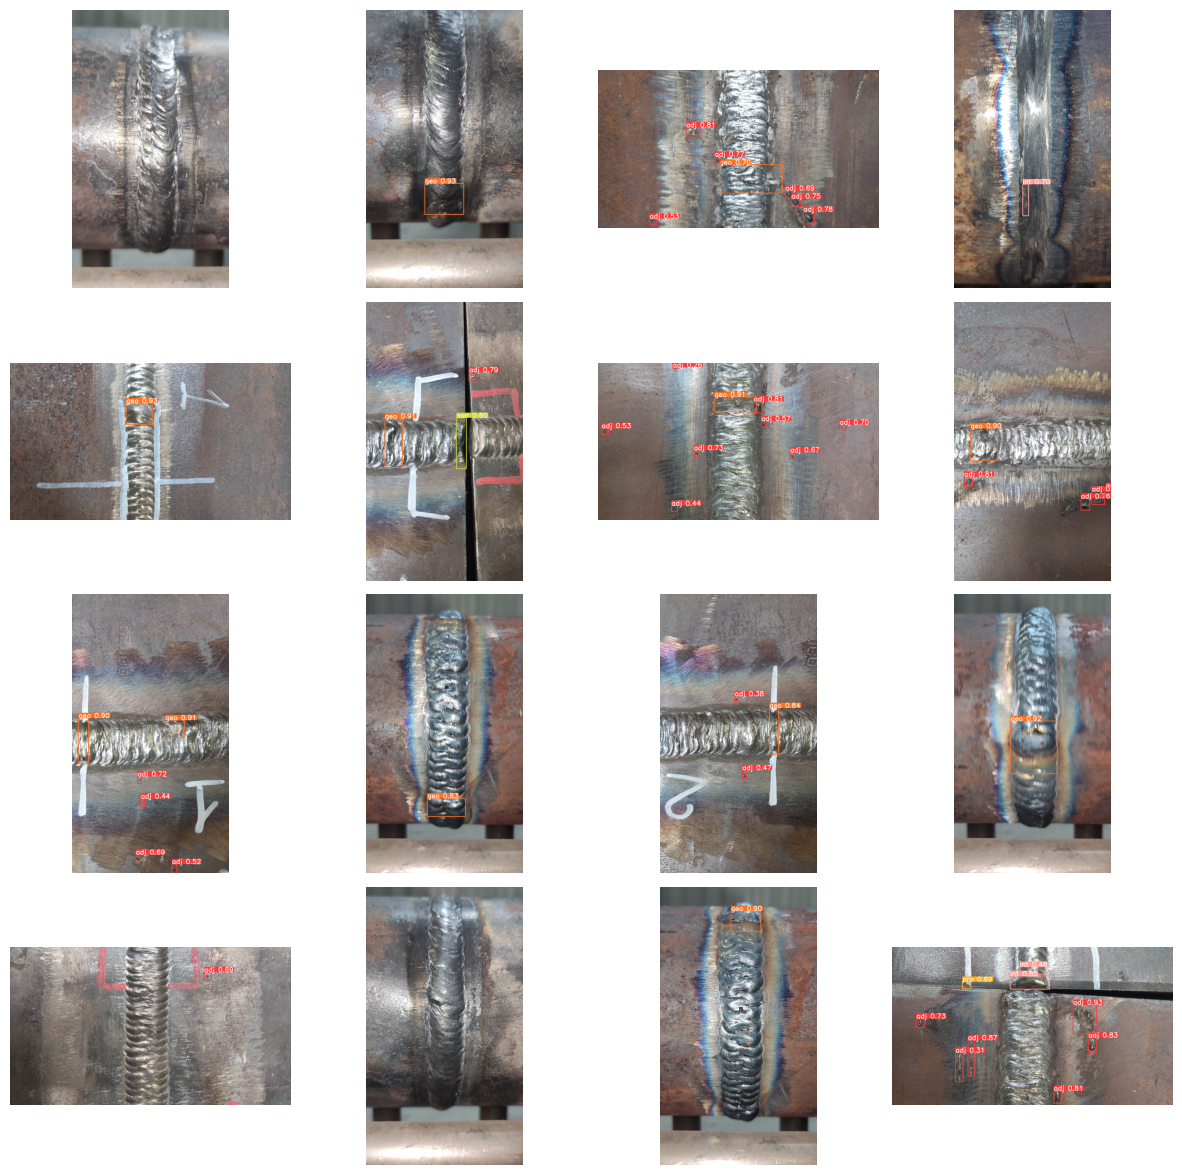

In [23]:
import random
import matplotlib.pyplot as plt

custom_image_dir = '/kaggle/working/yolo_dataset/images/val'

image_files = os.listdir(custom_image_dir)

selected_images = random.sample(image_files, 16)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))

for i, img_file in enumerate(selected_images):
    
    row_idx = i // 4
    col_idx = i % 4
    
    img_path = os.path.join(custom_image_dir, img_file)
    detect_img = detect(img_path)
    
    axes[row_idx, col_idx].imshow(detect_img)
    axes[row_idx, col_idx].axis('off')
    
plt.subplots_adjust(wspace=0.05, hspace=0.05)